In [1]:
from vivino_community_reviews import save_reviews, load_reviews
from vivino_community_reviews import vivino_reviews, concat_reviews, check_url

/home/lbk/.cache/pypoetry/virtualenvs/scrap2-pSsZr_wz-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import pandas as pd
import time

def read_csv(file, path_data, **kwargs):
    """
    kwargs: keyword args for pd.read_csv
    """
    files = [x for x in os.listdir(path_data) if x.startswith(file)]

    df_reviews = pd.DataFrame()
    for f in files:
        df = pd.read_csv(f'{path_data}/{f}', **kwargs)
        df_reviews = pd.concat([df_reviews, df])

    return df_reviews.reset_index(drop=True)

# Existing

In [3]:
file = 'wine_reviews_'
df_reviews = read_csv(file, 'data')
df_reviews.groupby(['wid', 'wine']).review_transl.count().sort_index(level=1)

wid  wine                                                
4    Aguirre Dos Copas Cabernet Sauvignon                       7
35   Balbi Soprani Moscato d'Asti                              31
29   Bread & Butter Cabernet Sauvignon                         32
28   Bread & Butter Pinot Noir                               1236
33   Canti Moscato d'Asti                                      71
0    Casillero del Diablo Cabernet Sauvignon (Reserva)        472
6    Casillero del Diablo Chardonnay (Reserva)                122
39   Castello del Poggio Moscato d'Asti                        80
11   Cono Sur Bicicleta Reserva Unoaked Chardonnay            109
9    Frontera Cabernet Sauvignon                              207
38   G.D. Vajra Moscato d'Asti                                 52
36   Gancia Moscato d'Asti N.V.                               160
7    Kendall-Jackson Vintner's Reserve Cabernet Sauvignon     121
27   Kendall-Jackson Vintner's Reserve Chardonnay             553
10   Long Barn Cha

# Scraping

## Setting

In [4]:
locator_ratings = "//a[@href='#all_reviews']"
locator_more = "//button[@tabindex='0']"
locator_recent = '//*[@data-testid="baseModalBackdrop"]/div[2]/div[2]/div[2]/div/a[1]'

locator_review = "communityReview__reviewText--2bfLj"
locator_date = "anchor_anchor__m8Qi- reviewAnchor__anchor--2NKFw reviewDate__reviewDate--49vpM undefined"

kwargs = {
    'loc1': locator_ratings,
    'loc2': locator_more,
    'loc3': locator_recent, 
    'loc4': locator_review,
    'loc5': locator_date
}

In [5]:
kwargs.update({
    'end_date': '20220101',
    'source': 'vivino',
    #'max_scr': 10, 'time_scr': 2, 'check_idx': 4
})

## wine list

In [19]:
from sentence_transformers import SentenceTransformer, util

def check_wines(wines, split='/'):
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    encode = lambda x: model.encode(x, convert_to_tensor=True)
    for name, url in wines.items():
        e1 = encode(name)
        csims = [util.pytorch_cos_sim(e1, encode(x)) for x in url.split(split)]
        #csim = max(csims)
        #print(csim)
        name2 = csims.index(max(csims))
        print(f'{name}: {name2}')

check_wines(wines)

Arione Moscato d'Asti: 3
Catena Cabernet Sauvignon: 3
Cono Sur Single Vineyard Syrah: 3
Cono Sur Single Vineyard Cabernet Sauvignon: 3
Cono Sur Single Vineyard Pinot Noir: 3
Cono Sur Single Vineyard Carmenere: 3
Cono Sur Single Vineyard Chardonnay: 3
Two Hands Angels' Share Shiraz: 3
Two Hands Gnarly Dudes Shiraz: 3
Two Hands Sexy Beast Cabernet Sauvignon: 3


In [39]:
from sentence_transformers import SentenceTransformer, util

def check_wines(wines, split='/'):
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    encode = lambda x: model.encode(x, convert_to_tensor=True)
    for name, url in wines.items():
        e1 = encode(name)
        parts = url.split(split)
        csims = [util.pytorch_cos_sim(e1, encode(x)) for x in parts]
        mc = max(csims)
        name2 = parts[csims.index(mc)]
        print(f'{mc.item():.2f}) {name}: {name2}')

check_wines(wines)

0.85) Arione Moscato d'Asti: arione-moscato-d-asti
0.89) Catena Cabernet Sauvignon: catena-mendoza-cabernet-sauvignon
0.69) Cono Sur Single Vineyard Syrah: cono-sur-santiago-single-vineyard-syrah-valle-de-san-antonio
0.83) Cono Sur Single Vineyard Cabernet Sauvignon: cono-sur-santiago-single-vineyard-cabernet-sauvignon
0.86) Cono Sur Single Vineyard Pinot Noir: cono-sur-santiago-single-vineyard-pinot-noir
0.84) Cono Sur Single Vineyard Carmenere: cono-sur-santiago-single-vineyard-carmenere
0.88) Cono Sur Single Vineyard Chardonnay: cono-sur-santiago-single-vineyard-chardonnay
0.91) Two Hands Angels' Share Shiraz: two-hands-angels-share-shiraz
0.89) Two Hands Gnarly Dudes Shiraz: two-hands-gnarly-dudes-shiraz
0.96) Two Hands Sexy Beast Cabernet Sauvignon: two-hands-sexy-beast-cabernet-sauvignon


In [43]:
#pd.DataFrame().from_dict(wines)
wines

{"Arione Moscato d'Asti": 'https://www.vivino.com/arione-moscato-d-asti/w/1154484?ref=nav-search',
 'Catena Cabernet Sauvignon': 'https://www.vivino.com/catena-mendoza-cabernet-sauvignon/w/1268655?ref=nav-search',
 'Cono Sur Single Vineyard Syrah': 'https://www.vivino.com/cono-sur-santiago-single-vineyard-syrah-valle-de-san-antonio/w/4750037?ref=nav-search',
 'Cono Sur Single Vineyard Cabernet Sauvignon': 'https://www.vivino.com/cono-sur-santiago-single-vineyard-cabernet-sauvignon/w/3875243?ref=nav-search',
 'Cono Sur Single Vineyard Pinot Noir': 'https://www.vivino.com/cono-sur-santiago-single-vineyard-pinot-noir/w/4303583?ref=nav-search',
 'Cono Sur Single Vineyard Carmenere': 'https://www.vivino.com/cono-sur-santiago-single-vineyard-carmenere/w/3884025?ref=nav-search',
 'Cono Sur Single Vineyard Chardonnay': 'https://www.vivino.com/cono-sur-santiago-single-vineyard-chardonnay/w/4348680?ref=nav-search',
 "Two Hands Angels' Share Shiraz": 'https://www.vivino.com/two-hands-angels-share

In [46]:
from sentence_transformers import SentenceTransformer, util

def check_wines(wines, split='/'):
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    encode = lambda x: model.encode(x, convert_to_tensor=True)

    list_n = list()
    list_u = list()
    list_s = list()
    
    for name, url in wines.items():
        e1 = encode(name)
        parts = url.split(split)
        csims = [util.pytorch_cos_sim(e1, encode(x)) for x in parts]
        mc = max(csims).item()
        name2 = parts[csims.index(mc)]
        #print(f'{mc.item():.2f}) {name}: {name2}')
        list_n.append(name)
        list_u.append(name2)
        list_s.append(mc)

    return (pd.DataFrame()
            .from_dict({'wine':list_n, 'url':list_u, 'similarity': list_s})
           .sort_values('similarity'))

df = check_wines(wines)
df

,wine,url,similarity
2,Cono Sur Single Vineyard Syrah,cono-sur-santiago-single-vineyard-syrah-valle-...,0.687737
3,Cono Sur Single Vineyard Cabernet Sauvignon,cono-sur-santiago-single-vineyard-cabernet-sau...,0.832239
5,Cono Sur Single Vineyard Carmenere,cono-sur-santiago-single-vineyard-carmenere,0.841585
0,Arione Moscato d'Asti,arione-moscato-d-asti,0.852157
4,Cono Sur Single Vineyard Pinot Noir,cono-sur-santiago-single-vineyard-pinot-noir,0.855775
6,Cono Sur Single Vineyard Chardonnay,cono-sur-santiago-single-vineyard-chardonnay,0.875668
1,Catena Cabernet Sauvignon,catena-mendoza-cabernet-sauvignon,0.888164
8,Two Hands Gnarly Dudes Shiraz,two-hands-gnarly-dudes-shiraz,0.891697
7,Two Hands Angels' Share Shiraz,two-hands-angels-share-shiraz,0.905157
9,Two Hands Sexy Beast Cabernet Sauvignon,two-hands-sexy-beast-cabernet-sauvignon,0.957168


In [12]:
f = 'data/wines_to_collect.txt'

with open(f, 'r') as file:
    w = file.read()

w = w.strip('\n').split('\n')
wines = {w[i]:w[i+1] for i in range(0, len(w), 2)}
len(wines)

10

In [13]:
id_start = df_reviews.wid.max() + 1
id_start

40

**load if the reviews of the wines not translated yet**

In [7]:
#files = []
files = ['wine_6']
path = 'data'

df_reviews = pd.DataFrame()
for f in files:
    df = load_reviews(f'{f}.csv', path=path)
    df_reviews = pd.concat([df_reviews, df])

# check duplicate wid
df_reviews.groupby('wid').wine.unique()

data/wine_6.csv loaded.


wid
6    [Casillero del Diablo Chardonnay (Reserva)]
Name: wine, dtype: object

**reset dataframe if no reviews unfinished**

In [9]:
df_reviews = pd.DataFrame()

In [10]:
# run if any wine failed
#wines = wines_failed

In [ ]:
sleep()

In [11]:
num_try = 3

col_rev = ['wid', 'wine', 'date', 'review', 'source']
path = 'data'
wines_failed = dict()

for i in range(num_try):
    print(f'scraping {i+1}', '*'*20)
    #for wine_name, wine_url in wines:
    for wine_name, wine_url in wines.items():
        try:
            df = vivino_reviews(wine_url, wine_name, **kwargs)
            df_reviews = concat_reviews(df_reviews, df, wine_name, col_rev, path=path, id_start=id_start)
        except:
            print(f'ERROR: check {wine_name}')
            wines_failed.update({wine_name: wine_url})

    if len(wines_failed) > 0:
        print(f'num of failed: {len(wines_failed)}\n')
        wines = wines_failed
        wines_failed = dict()
        time.sleep(3)
    else:
        break

scraping 1 ********************


43it [00:34,  1.25it/s]

Vietti Moscato d'Asti: 43 reviews collected.
data/wine_30.csv saved.



43it [00:04,  9.11it/s]


Villa M Bianco: 43 reviews collected.
data/wine_31.csv saved.


493it [12:04,  1.47s/it]


Michele Chiarlo Moscato d'Asti Nivole: 493 reviews collected.
data/wine_32.csv saved.


73it [00:45,  1.61it/s]


Canti Moscato d'Asti: 73 reviews collected.
data/wine_33.csv saved.


33it [00:04,  7.05it/s]


Vallebelbo Moscato d'Asti: 33 reviews collected.
data/wine_34.csv saved.


0it [00:00, ?it/s]


ERROR: check Tosti Moscato d'Asti


33it [00:08,  3.72it/s]


Balbi Soprani Moscato d'Asti: 33 reviews collected.
data/wine_35.csv saved.


0it [00:00, ?it/s]


ERROR: check G.D. Vajra Moscato d'Asti


0it [00:00, ?it/s]


ERROR: check Castello del Poggio Moscato d'Asti


163it [02:13,  1.22it/s]


Gancia Moscato d'Asti N.V.: 163 reviews collected.
data/wine_36.csv saved.
num of failed: 3

scraping 2 ********************


33it [00:04,  7.21it/s]


Tosti Moscato d'Asti: 33 reviews collected.
data/wine_37.csv saved.


53it [00:23,  2.21it/s]


G.D. Vajra Moscato d'Asti: 53 reviews collected.
data/wine_38.csv saved.


83it [00:43,  1.91it/s]

Castello del Poggio Moscato d'Asti: 83 reviews collected.
data/wine_39.csv saved.


In [12]:
df_reviews

,wid,wine,date,review,source
0,30,Vietti Moscato d'Asti,2024-01-21,Moscato molto buono. Non eccessivamente gassat...,vivino
1,30,Vietti Moscato d'Asti,2024-01-21,This wine has a strong fruity scent and a plea...,vivino
2,30,Vietti Moscato d'Asti,2024-01-15,Slightly sweeter but served cold. Really tasty...,vivino
3,30,Vietti Moscato d'Asti,2024-01-05,Wedding mascato!!,vivino
4,30,Vietti Moscato d'Asti,2024-01-04,"Комплексное, нежное игристое. Очень ароматное,...",vivino
...,...,...,...,...,...
78,39,Castello del Poggio Moscato d'Asti,2021-10-24,Excellent,vivino
79,39,Castello del Poggio Moscato d'Asti,2021-10-24,Purchased at Nautical Wheelers on 10/23/2021 f...,vivino
80,39,Castello del Poggio Moscato d'Asti,2017-03-26,Really enjoyed this one-full bodied with perfe...,vivino
81,39,Castello del Poggio Moscato d'Asti,2016-09-15,Shoutout to the Romans and Greeks!,vivino


**temp saving before translation**

In [13]:
df_reviews.groupby(['wid', 'wine']).review.count().sort_index(level=1)

wid  wine                                 
35   Balbi Soprani Moscato d'Asti              33
33   Canti Moscato d'Asti                      73
39   Castello del Poggio Moscato d'Asti        83
38   G.D. Vajra Moscato d'Asti                 53
36   Gancia Moscato d'Asti N.V.               163
32   Michele Chiarlo Moscato d'Asti Nivole    493
37   Tosti Moscato d'Asti                      33
34   Vallebelbo Moscato d'Asti                 33
30   Vietti Moscato d'Asti                     43
31   Villa M Bianco                            43
Name: review, dtype: int64

In [14]:
save_reviews(df_reviews, 'wine_reviews_tmp.csv', 'data', overwrite=True)

data/wine_reviews_tmp.csv saved.


# Review data

In [15]:
df_reviews = load_reviews('wine_reviews_tmp.csv', 'data')

data/wine_reviews_tmp.csv loaded.


In [16]:
cond = (df_reviews.date.isna()) | (df_reviews.review.isna())
df_reviews.loc[cond]

,wid,wine,date,review,source
40,30,Vietti Moscato d'Asti,2019-04-15,NaN,vivino
83,31,Villa M Bianco,NaT,NaN,vivino
566,32,Michele Chiarlo Moscato d'Asti Nivole,2022-01-01,NaN,vivino
576,32,Michele Chiarlo Moscato d'Asti Nivole,2022-02-07,NaN,vivino
715,35,Balbi Soprani Moscato d'Asti,2020-10-19,NaN,vivino
878,36,Gancia Moscato d'Asti N.V.,NaT,NaN,vivino
911,37,Tosti Moscato d'Asti,2018-05-28,NaN,vivino
964,38,G.D. Vajra Moscato d'Asti,NaT,NaN,vivino
1036,39,Castello del Poggio Moscato d'Asti,2021-12-17,NaN,vivino


In [17]:
df_reviews = df_reviews.loc[~cond].reset_index(drop=True)

In [18]:
df_reviews.date.dt.year.value_counts().sort_index(ascending=False)

date
2024     31
2023    315
2022    566
2021    110
2020     13
2019      3
2017      1
2016      1
2014      1
Name: count, dtype: int64

In [19]:
kwargs['end_date']

'20220101'

<Axes: >

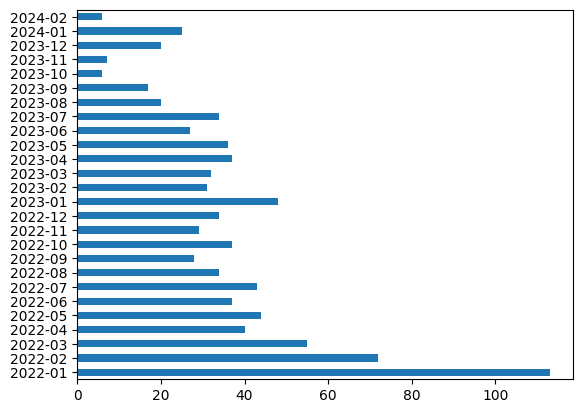

In [20]:
#d = df_reviews.date.agg(['min', 'max']).to_list()
d = [kwargs['end_date'], df_reviews.date.max()]

date_range = pd.date_range(start=d[0], end=d[1]).to_period("M").unique()

(df_reviews
 .set_index('date').to_period("M")
 .groupby(level=0).review.count()
 .sort_index()
 .reindex(date_range, fill_value=0)
 .plot(kind='barh')
)

<Axes: ylabel='wine'>

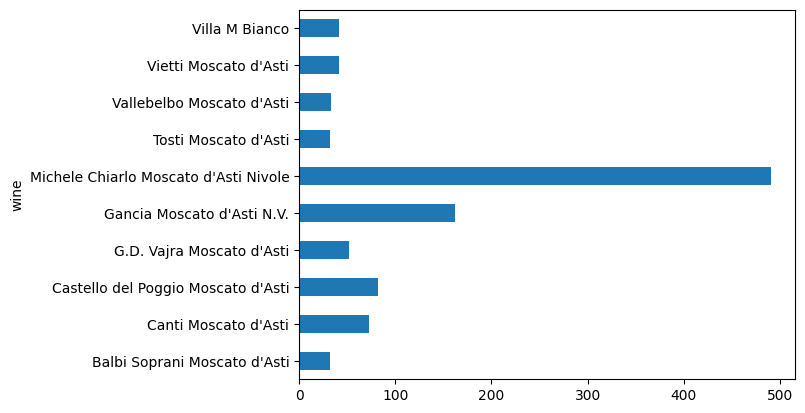

In [21]:
(df_reviews
 .groupby(by='wine').review.count()
 .plot(kind='barh')
)

In [22]:
df_reviews.head()

,wid,wine,date,review,source
0,30,Vietti Moscato d'Asti,2024-01-21,Moscato molto buono. Non eccessivamente gassat...,vivino
1,30,Vietti Moscato d'Asti,2024-01-21,This wine has a strong fruity scent and a plea...,vivino
2,30,Vietti Moscato d'Asti,2024-01-15,Slightly sweeter but served cold. Really tasty...,vivino
3,30,Vietti Moscato d'Asti,2024-01-05,Wedding mascato!!,vivino
4,30,Vietti Moscato d'Asti,2024-01-04,"Комплексное, нежное игристое. Очень ароматное,...",vivino


# Translate

In [23]:
import langdetect
import json
from deep_translator import GoogleTranslator
from tqdm import tqdm

def detect_language(text):
    try:
        return langdetect.detect(text)
    except KeyboardInterrupt as e:
        raise(e)
    except:
        return '<-- ERROR -->'

def get_translation(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(str(text))
    except KeyboardInterrupt as e:
        raise(e)
    except:
        return '<-- ERROR -->'

In [24]:
tmp_data = []

for rec in tqdm(df_reviews.to_dict('records')):
    tmp_data.append({
        #'wid': rec['wid'],
        'lang': detect_language(rec['review']),
        'review_transl': get_translation(rec['review'])
    })

100%|███████████████████████████████████████████████████████████| 1041/1041 [13:23<00:00,  1.30it/s]


In [25]:
df_reviews = df_reviews.merge(pd.DataFrame(tmp_data), left_index=True, right_index=True)
df_reviews.head()

,wid,wine,date,review,source,lang,review_transl
0,30,Vietti Moscato d'Asti,2024-01-21,Moscato molto buono. Non eccessivamente gassat...,vivino,it,Very good Moscato. Not overly carbonated and n...
1,30,Vietti Moscato d'Asti,2024-01-21,This wine has a strong fruity scent and a plea...,vivino,en,This wine has a strong fruity scent and a plea...
2,30,Vietti Moscato d'Asti,2024-01-15,Slightly sweeter but served cold. Really tasty...,vivino,en,Slightly sweeter but served cold. Really tasty...
3,30,Vietti Moscato d'Asti,2024-01-05,Wedding mascato!!,vivino,it,Mascato wedding!!
4,30,Vietti Moscato d'Asti,2024-01-04,"Комплексное, нежное игристое. Очень ароматное,...",vivino,ru,"Complex, delicate sparkling. Very aromatic, li..."


**check translation error**

In [26]:
cond = df_reviews.lang.str.contains('ERROR')
df_reviews.loc[cond]

,wid,wine,date,review,source,lang,review_transl
21,30,Vietti Moscato d'Asti,2023-04-03,😙😙😙,vivino,<-- ERROR -->,None
134,32,Michele Chiarlo Moscato d'Asti Nivole,2023-07-01,❤️❤️❤️❤️❤️,vivino,<-- ERROR -->,None
256,32,Michele Chiarlo Moscato d'Asti Nivole,2022-12-17,6/7,vivino,<-- ERROR -->,6/7
352,32,Michele Chiarlo Moscato d'Asti Nivole,2022-07-28,👍🏻,vivino,<-- ERROR -->,None
450,32,Michele Chiarlo Moscato d'Asti Nivole,2022-03-08,😊👍,vivino,<-- ERROR -->,None
459,32,Michele Chiarlo Moscato d'Asti Nivole,2022-03-01,4.0 ⭐️,vivino,<-- ERROR -->,4.0 ⭐️
469,32,Michele Chiarlo Moscato d'Asti Nivole,2022-02-22,👌🏾👌🏾👌🏾,vivino,<-- ERROR -->,None
506,32,Michele Chiarlo Moscato d'Asti Nivole,2022-01-21,!,vivino,<-- ERROR -->,None
529,32,Michele Chiarlo Moscato d'Asti Nivole,2022-01-08,.,vivino,<-- ERROR -->,None
545,32,Michele Chiarlo Moscato d'Asti Nivole,2022-01-01,4.1,vivino,<-- ERROR -->,4.1


In [ ]:
#cond = df_reviews.review_transl.isna()
#df_reviews.loc[cond]

In [27]:
df_reviews = df_reviews.loc[~cond]

**save final data**

In [28]:
from datetime import datetime
d = datetime.today().strftime('%y%m%d')
save_reviews(df_reviews, f'wine_reviews_{d}.csv')

data/wine_reviews_240213.csv saved.


In [31]:
!unzip -l wine_reviews.zip

Archive:  wine_reviews.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
   343369  2024-02-07 16:58   wine_reviews_240124.csv
   334512  2024-02-07 18:16   wine_reviews_240207.csv
   529775  2024-02-12 20:13   wine_reviews_240212.csv
   213076  2024-02-13 16:19   wine_reviews_240213.csv
---------                     -------
  1420732                     4 files


In [30]:
!zip -uj wine_reviews.zip data/wine_reviews_2*csv

  adding: wine_reviews_240213.csv (deflated 71%)


In [31]:
#!zip -j wine_reviews.zip data/wine_reviews_2*csv

  adding: wine_reviews_240124.csv (deflated 70%)
  adding: wine_reviews_240207.csv (deflated 69%)
